In [ ]:
!pip install torch

In [ ]:
!pip install torcheval

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import f1_score
from IPython.display import clear_output
from tqdm import tqdm
from torcheval.metrics.functional import multiclass_f1_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os, sys, json
import urllib.parse as ul

sys.argv.append('.') if len(sys.argv) == 2 else None

base_url = 'https://cloud-api.yandex.net:443/v1/disk/public/resources/download?public_key='
url = ul.quote_plus('https://downloader.disk.yandex.ru/zip/b74b394f0e699adf0d46b56432f8fc6c6e4876194ce6577d917442588fef3f4b/66ed34a2/dnl6cktEN2JrdjdxdzVkWk9HWVJWT21oOXFQODJTKzJlZEdNV25kc2tuL1VUbXg3OFllMGE5NkozU1F0SUtVZnEvSjZicG1SeU9Kb25UM1ZvWG5EYWc9PQ==?uid=0&filename=all_time-series.zip&disposition=attachment&hash=vyzrKD7bkv7qw5dZOGYRVOmh9qP82S%2B2edGMWndskn/UTmx78Ye0a96J3SQtIKUfq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&owner_uid=138056018&tknv=v2')
folder = 'data'
res = os.popen('wget -qO - {}{}'.format(base_url, url)).read()
json_res = json.loads(res)
filename = ul.parse_qs(ul.urlparse(json_res['href']).query)['filename'][0]
os.system("wget '{}' -P '{}' -O '{}'".format(json_res['href'], folder, filename))

In [ ]:
!unzip all_time-series.zip

Archive:  all_time-series.zip
replace all_time-series/readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!python generate.py

python3: can't open file '/content/generate.py': [Errno 2] No such file or directory


In [ ]:
!mkdir data
!mkdir data/ts_cut
!mkdir data/ts_cut/HCPex

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/ts_cut’: File exists
mkdir: cannot create directory ‘data/ts_cut/HCPex’: File exists


In [ ]:
data = {}

path_to_data = r'all_time-series/ts_cut'

import os
import numpy as np
import re

parser_regex = r'(ihb|china|rmet)_(open|close)_strategy-(\d)_(GSR|noGSR).npy'
extractor = re.compile(parser_regex)

items = {atlas_name : {dataset_name : []
                       for dataset_name in ['china', 'ihb', 'rmet']}
         for atlas_name in ['HCPex', 'Brainnetome', 'AAL', 'Schaefer200']}

for root, dirs, files in os.walk(path_to_data):
    for file in files:
        atlas = root.split(os.sep)[2]
        source = root.split(os.sep)[3]
        items[atlas][source].append(np.load(os.path.join(root, file)))

In [ ]:
data = pd.DataFrame(items['Brainnetome']['rmet'][0][0])

In [ ]:
data.shape

(120, 246)

In [ ]:
corr_matrix = data.corr()

In [ ]:
corr_matrix2 = np.corrcoef(data.T)

In [ ]:
corr_matrix.values.flatten().shape

(60516,)

<Axes: >

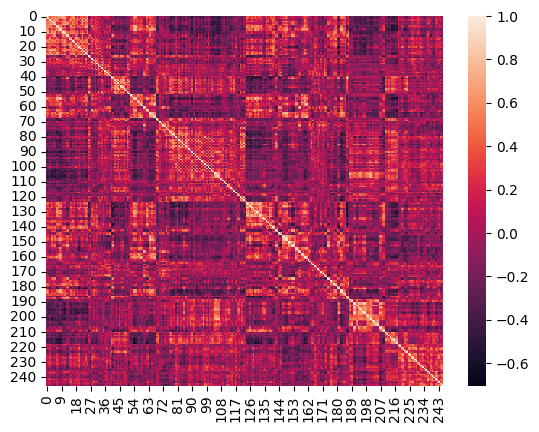

In [ ]:
sns.heatmap(corr_matrix)


# Dataset


In [ ]:
data = items['Brainnetome']['rmet']

In [ ]:
data = np.array([np.corrcoef(person, rowvar=False) for tag in data for i, person in enumerate(tag)])

In [ ]:
data.shape

(1512, 246, 246)

In [ ]:
rows, cols = np.triu_indices(data.shape[1])
features = data[:, rows, cols]
labels = np.array([i % 63 for i in range(1512)])

In [ ]:
features.shape

(1512, 30381)

In [ ]:
labels.shape

(1512,)

In [ ]:
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

In [ ]:
features_tensor.shape

torch.Size([1512, 30381])

In [ ]:
dataset = TensorDataset(features_tensor, labels_tensor)

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class TLNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def loss_with_regularization(y_pred, y, model, alpha=0.01, beta=0.01):
    loss = nn.CrossEntropyLoss()(y_pred, y)

    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)

    l1_reg = 0.0
    for param in model.parameters():
        l1_reg += torch.norm(param, p=1)

    loss += alpha * l1_reg + beta * l2_reg
    return loss

In [ ]:
def train(model, data_loader, optimizer, loss_fn):
    model.train()

    total_loss = 0
    total_f1 = 0

    for x, y in tqdm(data_loader):

        optimizer.zero_grad()

        output = model(x)
        loss = loss_with_regularization(output, y, model)

        loss.backward()

        total_loss += loss.item()

        y_pred = output.argmax(dim=1)
        f1 = multiclass_f1_score(y_pred, y, average='macro', num_classes=63).item()
        total_f1 += f1

        optimizer.step()

    return total_loss / len(data_loader), total_f1 / len(data_loader)


In [ ]:
# валидацонный цикл
@torch.inference_mode()
def evaluate(model, data_loader, loss_fn):
    model.eval()

    total_loss = 0
    total_f1 = 0

    for x, y in tqdm(data_loader):

        output = model(x)

        loss = loss_with_regularization(output, y, model)

        total_loss += loss.item()

        y_pred = output.argmax(dim=1)
        f1 = multiclass_f1_score(y_pred, y, average='macro', num_classes=63).item()
        total_f1 += f1

    return total_loss / len(data_loader), total_f1 / len(data_loader)

In [ ]:
# валидацонный цикл
@torch.inference_mode()
def test(model, data_loader, loss_fn):
    model.eval()

    total_loss = 0
    total_f1 = 0

    for x, y in tqdm(data_loader):

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        y_pred = output.argmax(dim=1)
        f1 = multiclass_f1_score(y_pred, y, average='macro', num_classes=63).item()
        total_f1 += f1
    clear_output()
    return total_loss / len(data_loader), total_f1 / len(data_loader)

In [ ]:
# вывод графиков
def plot_stats(train_loss, valid_loss, train_f1, valid_f1, title):
    plt.figure(figsize=(16, 5))

    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1, label='Train F1-score')
    plt.plot(valid_f1, label='Valid F1-score')
    plt.legend()

    plt.show()

In [ ]:
def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, model_name, title):
    train_loss_history, valid_loss_history = [], []
    train_f1_history, valid_f1_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_f1 = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_f1 = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_f1_history.append(train_f1)
        valid_f1_history.append(valid_f1)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_f1_history, valid_f1_history, title
            )

        print()
        print(f'Max valid F1-score: {max(valid_f1_history):.3f}')
        print(f'Min valid loss: {min(valid_loss_history):.3f}')

In [ ]:
LR = 1e-3
NUM_EPOCHS = 5

In [ ]:
model = TLNet(input_size=30381, hidden_size=4000, output_size=63)
optim = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

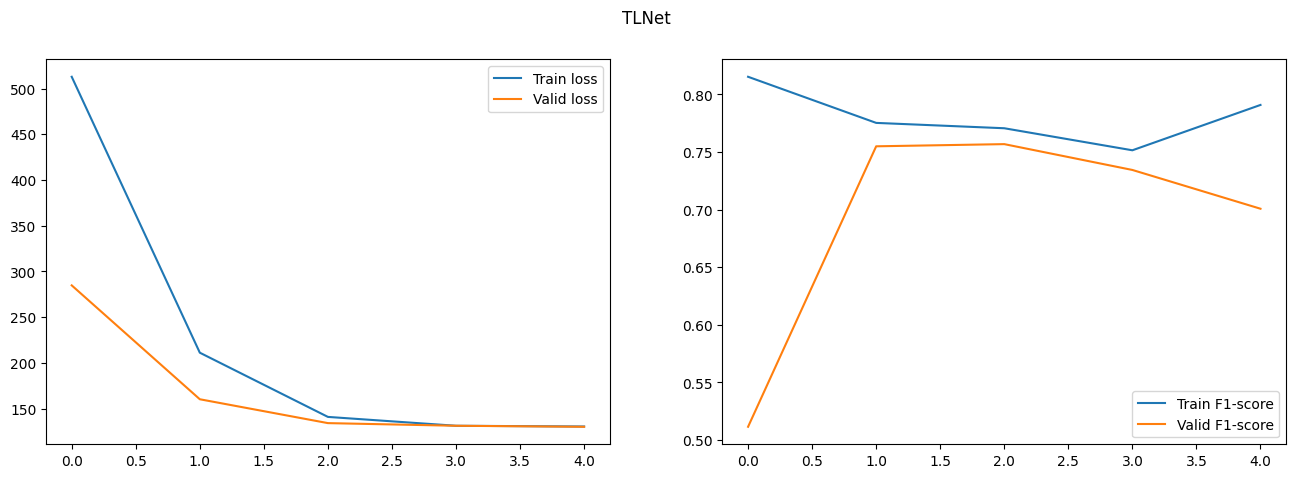


Max valid F1-score: 0.757
Min valid loss: 130.151


In [ ]:
fit(model, train_loader, val_loader,
    optim, criterion, NUM_EPOCHS, 'tlnet', "TLNet")

In [ ]:
test(model, test_loader, criterion)

(1.9490230679512024, 0.6317421644926071)

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')